In [79]:
#only run once
#!pip install nes-py==0.2.6
!apt-get update
!apt-get install ffmpeg libsm6 libxext6  -y
!apt install -y libgl1-mesa-glx
!pip install opencv-python
!pip install gym-super-mario-bros

zsh:1: command not found: apt-get
zsh:1: command not found: apt-get
The operation couldn’t be completed. Unable to locate a Java Runtime.
Please visit http://www.java.com for information on installing Java.



In [21]:
import torch
import torch.nn as nn
import random
import gym
import gym_super_mario_bros
from nes_py.wrappers import JoypadSpace
from gym_super_mario_bros import SuperMarioBrosEnv
from tqdm import tqdm
import pickle 
from gym_super_mario_bros.actions import RIGHT_ONLY, SIMPLE_MOVEMENT, COMPLEX_MOVEMENT
import gym
import numpy as np
import collections 
import cv2
import matplotlib.pyplot as plt
import time
import datetime

In [2]:
from toolkit.gym_env import *
from toolkit.model import *

%load_ext autoreload
%autoreload 2

In [3]:
def vectorize_action(action, action_space):
    # Given a scalar action, return a one-hot encoded action
    
    return [0 for _ in range(action)] + [1] + [0 for _ in range(action + 1, action_space)]

In [12]:
def show_state(env, ep=0, info=""):
    plt.figure(3)
    plt.clf()
    plt.imshow(env.render(mode='rgb_array'))
    plt.title("Episode: %d %s" % (ep, info))
    plt.axis('off')

    # display.clear_output(wait=True)
    # display.display(plt.gcf())
    display(plt.gcf(), clear=True)

In [18]:
def make_env(env, actions=SIMPLE_MOVEMENT):
    env = MaxAndSkipEnv(env)
    env = ProcessFrame84(env)
    env = ImageToPyTorch(env)
    env = BufferWrapper(env, 4)
    env = ScaledFloatFrame(env)
    return JoypadSpace(env, actions)

def generate_epoch_time_id():
    epoch_time = int(time.time())
    return str(epoch_time)

In [19]:
def save_checkpoint(agent, total_rewards, run_id):
    with open(f"ending_position-{run_id}.pkl", "wb") as f:
        pickle.dump(agent.ending_position, f)
    with open(f"num_in_queue-{run_id}.pkl", "wb") as f:
        pickle.dump(agent.num_in_queue, f)
    with open(f"total_rewards-{run_id}.pkl", "wb") as f:
        pickle.dump(total_rewards, f)
    if agent.double_dq:
        torch.save(agent.local_net.state_dict(), f"dq1-{run_id}.pt")
        torch.save(agent.target_net.state_dict(), f"dq2-{run_id}.pt")
    else:
        torch.save(agent.dqn.state_dict(), f"dq-{run_id}.pt")  
    torch.save(agent.STATE_MEM,  f"STATE_MEM-{run_id}.pt")
    torch.save(agent.ACTION_MEM, f"ACTION_MEM-{run_id}.pt")
    torch.save(agent.REWARD_MEM, f"REWARD_MEM-{run_id}.pt")
    torch.save(agent.STATE2_MEM, f"STATE2_MEM-{run_id}.pt")
    torch.save(agent.DONE_MEM,   f"DONE_MEM-{run_id}.pt")

In [16]:
def run(training_mode=True, pretrained=False, lr=0.00025, gamma=0.90, exploration_decay=0.99, exploration_min=0.02,
        mario_env='SuperMarioBros-1-1-v0', actions=SIMPLE_MOVEMENT, num_episodes=10, run_id=None):
   
    run_id = run_id or generate_epoch_time_id()
    fh = open(f'progress-{run_id}.txt', 'a')
    env = gym.make(mario_env)
    #env = gym_super_mario_bros.make('SuperMarioBros-v0')
    
    #env = make_env(env)  # Wraps the environment so that frames are grayscale 
    #env = SuperMarioBrosEnv()
    env = make_env(env, actions)
    observation_space = env.observation_space.shape
    action_space = env.action_space.n

    #todo: add agent params as a setting/create different agents in diff functions to run 

    agent = DQNAgent(state_space=observation_space,
                     action_space=action_space,
                     max_memory_size=30000,
                     batch_size=32,
                     gamma=gamma,
                     lr=lr,
                     dropout=0.,
                     exploration_max=1.0,
                     exploration_min=0.02,
                     exploration_decay=exploration_decay,
                     double_dq=True,
                     pretrained=pretrained,
                     run_id=run_id)
    
    
    # num_episodes = 10
    env.reset()
    total_rewards = []
    
    for ep_num in tqdm(range(num_episodes), file=fh):
        state = env.reset()
        state = torch.Tensor([state])
        total_reward = 0
        steps = 0
        while True:
            if not training_mode:
                show_state(env, ep_num)
            action = agent.act(state)
            steps += 1
            
            state_next, reward, terminal, info = env.step(int(action[0]))
            total_reward += reward
            state_next = torch.Tensor([state_next])
            reward = torch.tensor([reward]).unsqueeze(0)
            
            terminal = torch.tensor([int(terminal)]).unsqueeze(0)
            
            if training_mode:
                agent.remember(state, action, reward, state_next, terminal)
                agent.experience_replay()
            
            state = state_next
            if terminal:
                break

        total_rewards.append(total_reward)

        if training_mode and (ep_num % 300) == 0:
            save_checkpoint(agent, total_rewards, run_id)

        with open(f'total_reward-{run_id}.txt', 'a') as f:
            f.write("Total reward after episode {} is {}\n".format(ep_num + 1, total_rewards[-1]))
            if (ep_num%100 == 0):
                f.write("==================\n")
                f.write("{} current time at episode {}\n".format(datetime.datetime.now(), ep_num+1))
                f.write("==================\n")
            #print("Total reward after episode {} is {}".format(ep_num + 1, total_rewards[-1]))
            num_episodes += 1
    
    if training_mode:
        save_checkpoint(agent, total_rewards, run_id)
    
    env.close()
    fh.close()
    
    if num_episodes > 500:
        plt.title("Episodes trained vs. Average Rewards (per 500 eps)")
        plt.plot([0 for _ in range(500)] + 
                 np.convolve(total_rewards, np.ones((500,))/500, mode="valid").tolist())
        plt.show()

In [8]:
run(training_mode=True, pretrained=False)

  0%|          | 0/10 [00:00<?, ?it/s]/var/folders/dl/j59c8l716y3c186v0s1qgkf40000gp/T/ipykernel_18939/2976789740.py:30: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_2a19nf9hj1/croot/pytorch_1675190251927/work/torch/csrc/utils/tensor_new.cpp:204.)
  state = torch.Tensor([state])
/usr/local/Caskroom/miniconda/base/envs/marlios-env/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:227: DeprecationWarning: WARN: Core environment is written in old step API which returns one bool instead of two. It is recommended to rewrite the environment with new step API. 
  logger.deprecation(
 10%|█         | 1/10 [01:08<10:14, 68.24s/it]

Total reward after episode 1 is 793.0


 20%|██        | 2/10 [01:31<05:35, 41.93s/it]

Total reward after episode 2 is 233.0


 30%|███       | 3/10 [01:42<03:13, 27.58s/it]

Total reward after episode 3 is 231.0


 40%|████      | 4/10 [02:37<03:50, 38.48s/it]

Total reward after episode 4 is 621.0


 50%|█████     | 5/10 [02:45<02:17, 27.46s/it]

Total reward after episode 5 is 246.0


 60%|██████    | 6/10 [02:54<01:24, 21.13s/it]

Total reward after episode 6 is 249.0


 70%|███████   | 7/10 [03:01<00:50, 16.73s/it]

Total reward after episode 7 is 251.0


 80%|████████  | 8/10 [03:08<00:27, 13.53s/it]

Total reward after episode 8 is 250.0


 90%|█████████ | 9/10 [03:14<00:11, 11.23s/it]

Total reward after episode 9 is 251.0


100%|██████████| 10/10 [03:28<00:00, 20.86s/it]

Total reward after episode 10 is 251.0


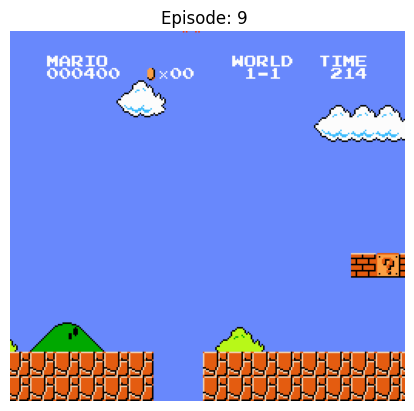

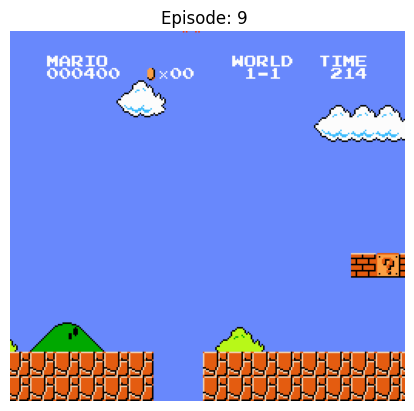

In [22]:
run(training_mode=False, pretrained=True, run_id='test')